In [26]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import os
import yaml
from pathlib import Path
import glob
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
from sklearn.metrics import mean_squared_error
from scipy import stats
from datetime import datetime, timedelta
import numpy as np

# In-situ data locations

In [27]:
def convert_date(date_string):
    # Function to convert date string to desired format
    if len(date_string.split()[0].split('.')[-1]) == 4:
        input_format = "%d.%m.%Y %H:%M"
    else:
        input_format = "%d.%m.%y %H:%M"
    output_format = "%Y-%m-%d %H:%M:%S"
    dt_object = datetime.strptime(date_string, input_format)
    return dt_object.strftime(output_format)
    
def load_data(data_path: str):
    """ 
    Load in situ data from gpkg or csv file

    :param data_path: str
    :return gdf: gpd.GeoDataFrame containing the data
    :return loc: str containing column name where locations stored
    :return traits: list containing columns of LAI and GCC stored
    """

    if data_path.endswith('.gpkg'):
        gdf = gpd.read_file(data_path).to_crs(crs='EPSG:2056').drop_duplicates()
        cols = gdf.columns
        trait = 'lai' if 'lai' in cols else 'gcc'
        loc = 'location' if 'location' in cols else None
        traits = ['lai']
        # Convert GCC to LAI
        if trait == 'gcc':
            gdf['lai'] = [None]*len(gdf)
            """ 
            gdf['lai'] = gdf['green_canopy_cover'] / 100
            """
            traits += ['green_canopy_cover']
        if not gdf['date'].apply(lambda x: isinstance(x, str)).all():
            # Convert date to string '%Y-%m-%d %H:%M:%S'
            gdf['date'] = gdf['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

    if data_path.endswith('csv'):
        gdf = pd.read_csv(data_path, delimiter=';').drop_duplicates()
        gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf['X'], gdf['Y']), crs='EPSG:2056')
        cols = gdf.columns
        """ 
        # Convert GCC to LAI where LAI is missing
        gdf['GLAI [m2/m2]'] = gdf.apply(lambda row: row['GreenCanopyCover [%]'] / 100 if pd.isnull(row['GLAI [m2/m2]']) else row['GLAI [m2/m2]'], axis=1)
        """ 
        gdf.rename(columns={'SiteName': 'location', 'GLAI [m2/m2]':'lai', 'GreenCanopyCover [%]':'green_canopy_cover'}, inplace=True)
        traits = ['lai', 'green_canopy_cover']     
        loc = 'location'
        gdf['date'] = gdf['Time'].apply(lambda x: convert_date(x))

    return gdf, loc, traits

In [28]:
insitu_paths = ['data/in-situ/in-situ_glai_2022.gpkg', 'data/in-situ/in-situ_glai_2023.gpkg',\
     'data/in-situ/in-situ_gcc_2022.gpkg', 'data/in-situ/WW_traits_PhenomEn_2022.csv','data/in-situ/WW_traits_PhenomEn_2023.csv']
insitu_paths = [base_dir.joinpath(p) for p in insitu_paths]

val_df = pd.DataFrame()

for insitu_path in insitu_paths:
  gdf, loc_col, trait_cols = load_data(str(insitu_path))
  #gdf = gdf.to_crs(2056)
  val_df = pd.concat([val_df, gdf], ignore_index=False)

/tmp/ipykernel_60821/3689570435.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_df = pd.concat([val_df, gdf], ignore_index=False)


In [30]:
locs = val_df.drop_duplicates('location')

In [58]:
swissbounds = '~/mnt/eo-nas1/eoa-share/projects/012_EO_dataInfrastructure/Project layers/swissBOUNDARIES3D_1_5_TLM_LANDESGEBIET.shp'
bounds = gpd.read_file(swissbounds)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


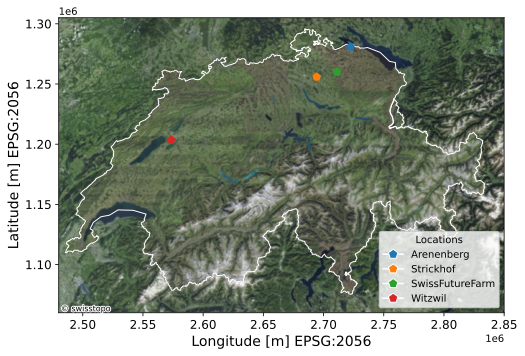

In [81]:
colors = plt.cm.tab10(range(len(locations)))

fig, ax = plt.subplots(figsize=(8,6))
bounds.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=1)
locs.plot(ax=ax, markersize=60, marker='p', color=colors)
# Set to extent of switzerland
minx, miny, maxx, maxy = [2480000, 1060000, 2850000, 1305000]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(ax, crs=pixs_gdf.crs, source=cx.providers.SwissFederalGeoportal.SWISSIMAGE) #
ax.set_xlabel('Longitude [m] EPSG:2056', fontsize=14)
ax.set_ylabel('Latitude [m] EPSG:2056', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
# Add legend
legend = ax.legend(loc='lower right')
legend.get_frame().set_edgecolor('white')  # Set legend border color
legend.get_frame().set_facecolor('white')  # Set legend fill color

# Add custom legend
locations = locs['location'].unique()  # Get unique location names
colors = plt.cm.tab10(range(len(locations)))  # Generate colors from colormap

# Create legend handles manually
legend_handles = [
    plt.Line2D(
        [0],
        [0],
        marker='p',
        color='w',
        markerfacecolor=colors[i],
        markersize=10,
        label=location
    )
    for i, location in enumerate(locations)
]

# Add legend to the plot
ax.legend(handles=legend_handles, title="Locations", loc="lower right")

plt.savefig('manuscript_figures/insitu_map.png')

# Bare soil samples: location

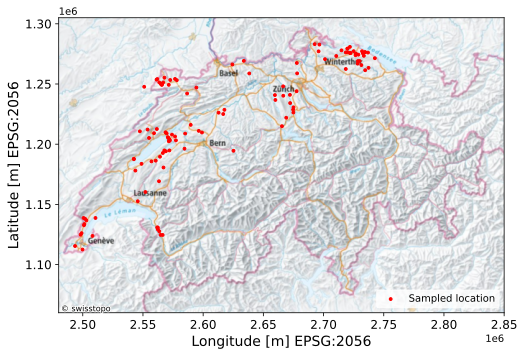

In [2]:
tiles = ['32TMT', '32TLT', '32TNT', '31TGM', '31TGN']

pixs_df = [pd.read_pickle(file) for tile_id in tiles for file in glob.glob(str(base_dir.joinpath(f'results/GEE_baresoil_v2/sampled_pixels_{tile_id}.pkl')))]
pixs_df = pd.concat(pixs_df, ignore_index=True)
pixs_gdf= gpd.GeoDataFrame(pixs_df, geometry=pixs_df.geometry, crs='EPSG:2056')

fig, ax = plt.subplots(figsize=(8,6))
pixs_gdf.plot(ax=ax, color='r', markersize=8, label='Sampled location')
# Set to extent of switzerland
minx, miny, maxx, maxy = [2480000, 1060000, 2850000, 1305000]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(ax, crs=pixs_gdf.crs, source=cx.providers.SwissFederalGeoportal.NationalMapColor) #
ax.set_xlabel('Longitude [m] EPSG:2056', fontsize=14)
ax.set_ylabel('Latitude [m] EPSG:2056', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xticklabels(ax.get_xticks(), fontsize=14)
#ax.set_yticklabels(ax.get_yticks(), fontsize=14)
#ax.set_title('Sampled bare soil spectra', fontsize=16)
# Add legend
legend = ax.legend(loc='lower right')
legend.get_frame().set_edgecolor('white')  # Set legend border color
legend.get_frame().set_facecolor('white')  # Set legend fill color
#plt.savefig('manuscript_figures/bare_soil_location_swissmap_legend.png')

# Bare soil samples: spectra
- compare spectra
- compare years?

In [ ]:
spectra = pd.read_pickle(base_dir.joinpath('results/GEE_baresoil_v2/sampled_spectra_all_CH.pkl'))

In [ ]:
from matplotlib import style 
print(plt.style.available)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

plt.style.use('default')

spectra.T.plot(ax=ax, legend=False, color='grey', linewidth=0.5, alpha=0.8)

# Plot the mean line in bold
mean_spectra = spectra.mean(axis=0)
mean_spectra_df = mean_spectra.reset_index().rename(columns={0: 'Reflectance'})
mean_spectra_df.columns = ['nm', 'Reflectance']
mean_spectra_df.plot(ax=ax, x='nm', y='Reflectance', color='royalblue', linewidth=2.5, label='Mean Reflectance')

plt.ylim((0,0.4))
plt.ylabel('Reflectance', fontsize=20)
plt.xlabel('Wavelength [nm]', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[-1]], labels=[labels[-1]], loc='upper right', fontsize=18)
plt.savefig('manuscript_figures/bare_soil_spectra_allgrey.png')
plt.show()

In [ ]:
# Plotting
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(figsize=(8, 5))

# Plot all spectra in grey
#spectra.T.plot(ax=ax, legend=False, color='grey', linewidth=0.5, alpha=0.3)

# Plot the mean line in bold
mean_spectra = spectra.mean(axis=0)
mean_spectra.plot(ax=ax, color='red', linewidth=1.5, label='Mean Reflectance')

# Calculate and plot the variation (standard deviation or error) at each band
wavelengths = spectra.columns.tolist()
max_spectra = spectra.max(axis=0) 
min_spectra = spectra.min(axis=0)  
plt.fill_between(wavelengths, min_spectra, max_spectra, label='Min-Max range', color='lightsteelblue', alpha=0.5)

std_spectra = spectra.std(axis=0) 
plt.fill_between(wavelengths, mean_spectra - std_spectra, mean_spectra + std_spectra, label='Standard deviation', color='pink', alpha=0.5)


# Customize plot appearance
plt.ylim((0, 0.4))  # Adjust ylim as needed
plt.ylabel('Reflectance', fontsize=16)
plt.xlabel('Wavelength [nm]', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# Save and show plot
plt.savefig('manuscript_figures/bare_soil_spectra_mean_variation.png')
plt.show()


# Addition of noise to spectra
- Effect of inverse 1 % on data

In [ ]:
# Open ray data

data_path = ['../../results/lut_based_inversion/soil_scaled/prosail_danner-etal_switzerland_S2A_lai-cab-ccc-car_lut_no-constraints.pkl', \
    '../../results/lut_based_inversion/soil_scaled/prosail_danner-etal_switzerland_S2B_lai-cab-ccc-car_lut_no-constraints.pkl']

if isinstance(data_path, str):
  df = pd.read_pickle(data_path)
elif isinstance(data_path, list):
  dfs = [pd.read_pickle(path) for path in data_path]
  df = pd.concat(dfs, axis=0, ignore_index=True)


# Open noisy data

noisy_path = '../../results/lut_based_inversion/soil_scaled/prosail_danner-etal_switzerland_lai-cab-ccc-car_lut_no-constraints_inverse1.pkl'
df_noise = pd.read_pickle(noisy_path)

In [ ]:
cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
x = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]
n = 20

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
axs = axs.flatten()

df_sample = df.sample(n, random_state=42)
axs[0].set_title('Original Data', fontsize=14) 
axs[0].plot(x, df_sample[cols].T, linestyle='-', color='grey', linewidth=0.6)
axs[0].set_ylim(0, 0.6) 
axs[0].set_xlabel('Wavelength [nm]', fontsize=14) 
axs[0].set_ylabel('Refelctance', fontsize=14) 

df_noise_sample = df_noise.sample(n, random_state=42)
axs[1].set_title(f'Inverse noise 1%', fontsize=14) 
axs[1].plot(x, df_noise_sample[cols].T, linestyle='-', color='grey', linewidth=0.6)
axs[1].set_xlabel('Wavelength [nm]', fontsize=14) 


plt.suptitle(f'Effect of gaussian noise on the reflectance spectra', fontsize=16)
plt.tight_layout()

In [ ]:
cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
x = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]
n = 30

fig, axs = plt.subplots(figsize=(8, 5))

df_sample = df.sample(n, random_state=42)
df_noise_sample = df_noise.sample(n, random_state=42)

axs.plot(x, df_sample[cols].T, linestyle='-', color='grey', linewidth=1, label='Original data')
axs.plot(x, df_noise_sample[cols].T, linestyle='--', color='royalblue', linewidth=0.6, label='Noisy data')

# Creating custom legend
original_line = plt.Line2D([], [], color='grey', linestyle='-', linewidth=1, label='Original data')
noisy_line = plt.Line2D([], [], color='royalblue', linestyle='--', linewidth=0.6, label='Noisy data')
axs.legend(handles=[original_line, noisy_line])

axs.set_ylim(0, 0.7) 
axs.set_xlabel('Wavelength [nm]', fontsize=14) 
axs.set_ylabel('Refelctance', fontsize=14) 
axs.set_title('Addition of noise to spectra')
#axs.legend()

# Effect of noise on model scores

In [ ]:
from matplotlib import style
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
noise_results = '../../results/noise_results_NNint_soil.xlsx'
df = pd.read_excel(noise_results)

In [ ]:
noise_levels = [1, 3, 5, 10, 15, 20]
noise_types = ['additive', 'multiplicative', 'combined', 'inverse', 'inverse_combined'] 

In [ ]:
mean_scores = df.drop(['Seed'], axis=1).groupby(['Dataset', 'Type', 'Level']).mean().reset_index()
std_scores = df.drop(['Seed'], axis=1).groupby(['Dataset', 'Type', 'Level']).std().reset_index()

dataset = 'Test'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

mean_scores_dataset = mean_scores[mean_scores['Dataset'] == dataset]
std_scores_dataset = std_scores[std_scores['Dataset'] == dataset]

# Plot RMSE for each noise type
for noise_type in noise_types:
    mean_rmse = mean_scores_dataset[mean_scores_dataset['Type'] == noise_type]['RMSE']
    std_rmse = std_scores_dataset[std_scores_dataset['Type'] == noise_type]['RMSE']
    ax.errorbar(noise_levels, mean_rmse, yerr=std_rmse, label=noise_type, capsize=5)
ax.set_xticks(noise_levels)
ax.tick_params(axis='both', which='major', labelsize=14) 
ax.set_xlabel('Noise Level [%]', size=18)
ax.set_ylabel('RMSE', size=18)
ax.set_ylim(0.5,1.6)

legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='14')

#plt.savefig('manuscript_figures/NNint_soil_noise_RMSE.png')

In [ ]:
mean_scores = df.drop(['Seed'], axis=1).groupby(['Dataset', 'Type', 'Level']).mean().reset_index()
std_scores = df.drop(['Seed'], axis=1).groupby(['Dataset', 'Type', 'Level']).std().reset_index()

dataset = 'Test'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

mean_scores_dataset = mean_scores[mean_scores['Dataset'] == dataset]
std_scores_dataset = std_scores[std_scores['Dataset'] == dataset]

# Plot R2 for each noise type
for noise_type in noise_types:
    mean_rmse = mean_scores_dataset[mean_scores_dataset['Type'] == noise_type]['r2']
    std_rmse = std_scores_dataset[std_scores_dataset['Type'] == noise_type]['r2']
    ax.errorbar(noise_levels, mean_rmse, yerr=std_rmse, label=noise_type, capsize=5)
ax.set_xticks(noise_levels)
ax.tick_params(axis='both', which='major', labelsize=14) 
ax.set_xlabel('Noise Level [%]', size=18)
ax.set_ylabel('R2', size=18)
ax.set_ylim(0.7,1)

legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='14')

plt.savefig('NNint_soil_noise_r2.png')

# Model performances
- compare no soil vs soil

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
import torch
from pathlib import Path
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from models import MODELS
import seaborn as sns

In [5]:
from matplotlib import style 
print(plt.style.available)
plt.style.use('seaborn-v0_8-darkgrid')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [27]:
def prepare_data_test(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''

  data_path = config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle('../' + data_path)
    X_train = df[config['Data']['train_cols']]
    y_train = df[config['Data']['target_col']]

    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X_train = scaler.transform(X_train)
      return X_train, y_train
    else:
      return X_train.values, y_train

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle('../' +path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    # Sample 50000 data pairs
    #sampled_df = concatenated_df.sample(50000, random_state=config['Seed']) if len(concatenated_df) > 50000 else concatenated_df
    X_train = concatenated_df[config['Data']['train_cols']] #sampled_df[config['Data']['train_cols']] #
    y_train = concatenated_df[config['Data']['target_col']] #sampled_df[config['Data']['target_col']] #  

    #print(len(X_train), len(X_test))
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X_train = scaler.transform(X_train)
      return X_train, y_train
    else:
      return X_train.values, y_train

  else:
      return None


def prepare_data_val(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare test sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['val_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    df = df[~df[config['Data']['target_col']].isna()]
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])
      

    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    concatenated_df = concatenated_df[~concatenated_df[config['Data']['target_col']].isna()]
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])
      
          
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None


def compute_other_scores(y_test, y_pred, dataset, score_path):
    """ 
    Compute nromalised RMSE and pearson's r squared, and add to score_path
    """

    # Move y_pred to CPU if it's on CUDA device
    if isinstance(y_pred, torch.Tensor) and y_pred.device.type == 'cuda':
        y_pred = y_pred.cpu().detach().numpy()
    if isinstance(y_test, torch.Tensor) and y_test.device.type == 'cuda':
        y_test = y_test.cpu().detach().numpy()

    nrmse = mean_squared_error(y_test, y_pred, squared=False)/(np.max(y_test) - np.min(y_test))
    pearson = stats.pearsonr(y_test, y_pred).statistic

    print(f'nRMSE: {nrmse}')
    print(f'Pearson r2: {pearson**2}')
    """
    # Open excel file at score_path and append results
    score_data = {
        'Dataset': [dataset],
        'nRMSE': [nrmse],
        'r2': [pearson**2],
    }
    score_df = pd.DataFrame(score_data)
    """
    if score_path is not None:
      if os.path.exists(score_path):
          existing_df = pd.read_excel(score_path)
          if 'nRMSE' not in existing_df.columns:
              existing_df['nRMSE'] = [None]*len(existing_df)
          existing_df.loc[existing_df['Dataset'] == dataset, 'nRMSE']= nrmse
          if 'r2' not in existing_df.columns:
              existing_df['r2'] = [None]*len(existing_df)
          existing_df.loc[existing_df['Dataset'] == dataset, 'r2'] = pearson**2
        
          existing_df.to_excel(score_path, index=False)

    return



#############################################
# LOAD CONFIG

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

if not isinstance(config['Seed'], list):
    config['Seed'] = [config['Seed']]

model_basename = config['Model']['save_path']
gpu = config['Model'].pop('gpu')
save_model = config['Model'].pop('save') # dont need it but remove it from config

# Save preditions of each seed 
y_test_full = []
y_val_full = []

for seed in config['Seed']:
    print('Running with seed', seed)

    config['Model']['save_path'] = model_basename.split('.')[0] + f'{seed}.pkl'

    #############################################
    # PREPARE DATA

    X_test, y_test = prepare_data_test(config=config) # performance on testign synthetic data
    X_val, y_val = prepare_data_val(config=config) # unseen validation data (in situ)

    # Move data to CUDA if GPUs requested and available
    device = torch.device('cuda' if config['Model'].get('gpu') and torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
      X_test, X_val, y_test, y_val = (
        torch.FloatTensor(X_test).to(device),
        torch.FloatTensor(X_val).to(device),
        torch.FloatTensor(y_test).view(-1, 1).to(device),
        torch.FloatTensor(y_val).view(-1, 1).to(device),
      ) 

    #############################################
    # MODEL
    
    model_name = config['Model']['name']
    model_filename = '../' + config['Model'].pop('save_path') 
    with open(model_filename, 'rb') as f:
      model = pickle.load(f)

    if gpu and torch.cuda.is_available():
      print('Using GPUs')
      model.to(device)

    #############################################
    # TEST
    
    if not isinstance(y_test, pd.Series):
      y_test = y_test.flatten()
      y_val = y_val.flatten()

    print('---Test set scores---')
    y_pred_test = model.predict(X_test=X_test)
    model.test_scores(y_test=y_test, y_pred=y_pred_test.flatten(), dataset=f'Test {seed}', score_path='nb_test.xlsx') 
    # Compute r2 and nRMSE
    compute_other_scores(y_test=y_test, y_pred=y_pred_test.flatten(), dataset=f'Test {seed}', score_path='nb_test.xlsx')  
    print('---Validation set scores---')
    y_pred_val = model.predict(X_test=X_val)
    model.test_scores(y_test=y_val, y_pred=y_pred_val.flatten(), dataset=f'Val {seed}', score_path='nb_test.xlsx') 
    # Compute r2 and nRMSE
    compute_other_scores(y_test=y_val, y_pred=y_pred_val.flatten(), dataset=f'Val {seed}', score_path='nb_test.xlsx') 
    
    if not isinstance(y_test, pd.Series):
      y_test = y_test.cpu().numpy()
      y_val = y_val.cpu().numpy()

    y_test_full.append(y_pred_test)
    y_val_full.append(y_pred_val)

y_pred_test = np.mean(y_test_full, axis=0)
y_pred_val = np.mean(y_val_full, axis=0)

Running with seed 0
Using GPUs
---Test set scores---
Test 0 RMSE: 0.7892888772386537
Test 0 MAE: 0.5492522858524838
Test 0 R2: 0.89444008546643
Regression slope: 0.8640364044637429
Regression intercept: 0.4031196337036604
Test 0 rmselow: 0.3241872072088013
nRMSE: 0.09867292204188051
Pearson r2: 0.8970870057264013
---Validation set scores---
Val 0 RMSE: 1.1605404294358248
Val 0 MAE: 0.9235866258771891
Val 0 R2: 0.1772141446895471
Regression slope: 0.40441221828155266
Regression intercept: 2.0749010845148277
Val 0 rmselow: 0.9583467081897648
nRMSE: 0.17920738970451197
Pearson r2: 0.30028677297995543
Running with seed 1
Using GPUs
---Test set scores---
Test 1 RMSE: 0.7928945091456773
Test 1 MAE: 0.5516223331580689
Test 1 R2: 0.8934734443308783
Regression slope: 0.8851757831927044
Regression intercept: 0.2738677824492111
Test 1 rmselow: 0.3181035817484961
nRMSE: 0.09912367999164176
Pearson r2: 0.8971537161056441
---Validation set scores---
Val 1 RMSE: 1.2266234114561712
Val 1 MAE: 0.959305

In [28]:
# Compute mean and std of scores

score_df = pd.read_excel('nb_test.xlsx')
score_df['Dataset'] = score_df['Dataset'].apply(lambda x: x.split(' ')[0])
mean_scores = score_df.groupby('Dataset').mean().reset_index()
std_scores = score_df.groupby('Dataset').std().reset_index()

textstr_test = f'RMSE: {mean_scores[mean_scores.Dataset=="Test"].RMSE.values[0]:.3f}\nnRMSE: {mean_scores[mean_scores.Dataset=="Test"].nRMSE.values[0]:.3f}\n$R^2$: {mean_scores[mean_scores.Dataset=="Test"].r2.values[0]:.3f}'
textstr_val = f'RMSE: {mean_scores[mean_scores.Dataset=="Val"].RMSE.values[0]:.3f}\nnRMSE: {mean_scores[mean_scores.Dataset=="Val"].nRMSE.values[0]:.3f}\n$R^2$: {mean_scores[mean_scores.Dataset=="Val"].r2.values[0]:.3f}'

In [29]:
mean_scores

Dataset      RMSE       MAE        R2     Slope  Intercept   RMSelow  \
0    Test  0.789037  0.556170  0.894431  0.885343   0.328171  0.351973   
1     Val  1.163928  0.912568  0.171564  0.469675   1.784501  0.845171   

      nRMSE        r2  
0  0.098641  0.901307  
1  0.179730  0.336084

In [ ]:
# Plot ypred vs ytest
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(figsize=(6,6))


# Calculate the point density
xy = np.vstack([np.array(y_test).reshape(-1),np.array(y_pred_test).reshape(-1) ])
z = gaussian_kde(xy)(xy)

#axs[0].scatter(y_test, y_pred_test)
scatter = axs.scatter(y_test, y_pred_test, c=z, cmap='viridis')
axs.set_xlabel('Test set LAI', size=18)
axs.set_ylabel('Predicted LAI', size=18)
axs.set_xlim((-0.3,8))
axs.set_ylim((-0.3,8))
ticks = np.arange(0, 9, 2)  # Adjust the range and step size as needed
axs.set_xticks(ticks)
axs.set_yticks(ticks)
axs.tick_params(axis='both', which='major', labelsize=16) 

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs.text(0.03, 0.75, textstr_test, transform=axs.transAxes, fontsize=16, bbox=props)

# Plot y=x line
axs.plot([0, 8], [0, 8], color='gray', linestyle='--')

# Hide the top and right spine
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)

cbar = fig.colorbar(scatter, ax=axs)
cbar.set_label('Density', size=14)
cbar.ax.tick_params(labelsize=14)

#plt.savefig('manuscript_figures/NNint_nosoil_tuned_test.png')

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))

axs.scatter(y_val, y_pred_val)
axs.set_xlabel('Validation set LAI', size=18)
axs.set_ylabel('Predicted LAI', size=18)
ticks = np.arange(0, 9, 2)  # Adjust the range and step size as needed
axs.set_xticks(ticks)
axs.set_yticks(ticks)
axs.tick_params(axis='both', which='major', labelsize=16) 
axs.set_xlim((0,8))
axs.set_ylim((0,8))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs.text(0.03, 0.75, textstr_val, transform=axs.transAxes, fontsize=16, bbox=props)

# Plot y=x line
axs.plot([0, 8], [0, 8], color='gray', linestyle='--')

# Hide the top and right spine
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)

plt.savefig('manuscript_figures/NNint_nosoil_tuned_val.png')

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))

axs.scatter(y_val, y_pred_val)
axs.set_xlabel('Validation set LAI', size=18)
axs.set_ylabel('Predicted LAI', size=18)
ticks = np.arange(0, 9, 2)  # Adjust the range and step size as needed
axs.set_xticks(ticks)
axs.set_yticks(ticks)
axs.tick_params(axis='both', which='major', labelsize=16) 
axs.set_xlim((0,8))
axs.set_ylim((0,8))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs.text(0.03, 0.70, textstr_val, transform=axs.transAxes, fontsize=16, bbox=props)

# Plot y=x line
axs.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

# Plot regression line
slope = mean_scores[mean_scores.Dataset == 'Val'].Slope.values
intercept = mean_scores[mean_scores.Dataset == 'Val'].Intercept.values
xseq = np.linspace(0, 8, num=100)
axs.plot(xseq, intercept + slope * xseq, color="r", linestyle='--', label='Linear fit')
handles, labels = axs.get_legend_handles_labels()
axs.legend(fontsize=16)

# Hide the top and right spine
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)

#plt.savefig('manuscript_figures/NNint_soil_tuned_val_regression.png')

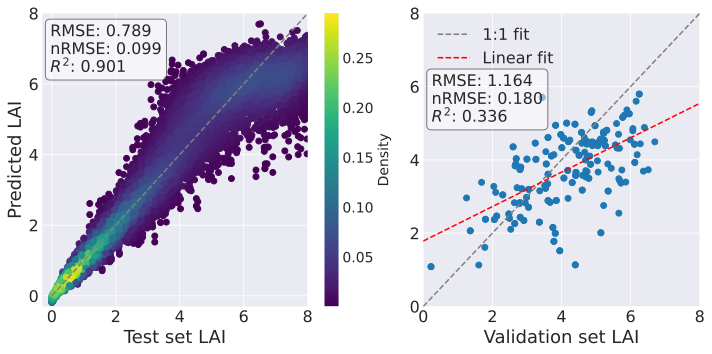

In [30]:
# Plot ypred vs ytest
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), gridspec_kw={'width_ratios': [1.2, 1]})


# Calculate the point density
xy = np.vstack([np.array(y_test).reshape(-1),np.array(y_pred_test).reshape(-1) ])
z = gaussian_kde(xy)(xy)

#axs[0].scatter(y_test, y_pred_test)
scatter = axs[0].scatter(y_test, y_pred_test, c=z, cmap='viridis')
axs[0].set_xlabel('Test set LAI', size=18)
axs[0].set_ylabel('Predicted LAI', size=18)
axs[0].set_xlim((-0.3,8))
axs[0].set_ylim((-0.3,8))
ticks = np.arange(0, 9, 2)  # Adjust the range and step size as needed
axs[0].set_xticks(ticks)
axs[0].set_yticks(ticks)
axs[0].tick_params(axis='both', which='major', labelsize=16) 

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs[0].text(0.03, 0.8, textstr_test, transform=axs[0].transAxes, fontsize=16, bbox=props)

# Plot y=x line
axs[0].plot([0, 10], [0, 10], color='gray', linestyle='--')

# Hide the top and right spine
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)

cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('Density', size=14)
cbar.ax.tick_params(labelsize=14)


axs[1].scatter(y_val, y_pred_val)
axs[1].set_xlabel('Validation set LAI', size=18)
#axs[1].set_ylabel('Predicted LAI', size=18)
ticks = np.arange(0, 9, 2)  # Adjust the range and step size as needed
axs[1].set_xticks(ticks)
axs[1].set_yticks(ticks)
axs[1].tick_params(axis='both', which='major', labelsize=16) 
axs[1].set_xlim((0,8))
axs[1].set_ylim((0,8))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axs[1].text(0.03, 0.63, textstr_val, transform=axs[1].transAxes, fontsize=16, bbox=props)

# Plot y=x line
axs[1].plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

# Plot regression line
slope = mean_scores[mean_scores.Dataset == 'Val'].Slope.values
intercept = mean_scores[mean_scores.Dataset == 'Val'].Intercept.values
xseq = np.linspace(0, 8, num=100)
axs[1].plot(xseq, intercept + slope * xseq, color="r", linestyle='--', label='Linear fit')
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(fontsize=16)

# Hide the top and right spine
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)

plt.tight_layout()
plt.savefig('manuscript_figures/NNint_soil_tuned_testval_r2.png')

# SNAP LAI predictions

- scatter plot

In [ ]:
import sys
base_dir = str(Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent) + '/SNAP_LAI'
sys.path.append(base_dir)
import biophys 
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Run SNAP on validation set

data_path = '../../results/validation_data_extended_angles_shift.pkl'
df = pd.read_pickle(data_path)
df = df[~df.lai.isna()]

# Compute LAI
df_lai = biophys.run_snap_biophys(df, "LAI")

In [ ]:
y_test_snap = df_lai.lai.values
y_pred_snap = df_lai.snap_LAI.values

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid') 

y_test_snap = df_lai.lai.values
y_pred_snap = df_lai.snap_LAI.values

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test_snap, y_pred_snap)
ax.set_xlabel('Validation LAI', fontsize=16)
ax.set_ylabel('Predicted LAI', fontsize=16)
#ax.set_title(f'{title}', fontsize=18)
ax.set_xlim((0,8))
ax.set_ylim((0,8))
ax.tick_params(axis='both', which='major', labelsize=16)

# Plot y=x line
ax.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

# Plot regression line
slope, intercept = np.polyfit(y_test_snap.flatten(), y_pred_snap.flatten(), 1)
xseq = np.linspace(0, 8, num=100)
ax.plot(xseq, intercept + slope * xseq, color="r", linestyle='--', label='Linear fit')
ax.legend(fontsize=16)

# Compute RMSE and R2
rmse = mean_squared_error(y_test_snap, y_pred_snap, squared=False)
r2 = r2_score(y_test_snap, y_pred_snap)

# Text for displaying on plot
textstr = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}\nSlope: {slope:.2f}\nIntercept: {intercept:.2f}'

# TO DO: add R2 and RMSE to plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.03, 0.70, textstr, transform=ax.transAxes, fontsize=16,
        bbox=props)

plt.savefig(f'manuscript_figures/SNAP_preds_simple.png')
plt.show()

In [ ]:
# Create a DataFrame
data = pd.DataFrame({'Validation LAI': y_test_snap, 'Predicted LAI': y_pred_snap.flatten()})

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')

# Create lmplot without regression line and legend
g = sns.lmplot(x='Validation LAI', y='Predicted LAI', data=data, height=8, aspect=1, 
        scatter_kws={'s': 50, 'alpha': 1}, fit_reg=False, legend=True)

# Manually plot the regression line
ax = g.ax
sns.regplot(x='Validation LAI', y='Predicted LAI', data=data, ax=ax, scatter=False, 
        line_kws={'color': 'red'}, label='Linear fit')


# Customize the plot
ax.set_xlabel('Validation LAI', fontsize=16)
ax.set_ylabel('Predicted LAI', fontsize=16)
#ax.set_title(f'{title}', fontsize=18)
ax.set_xlim((0, 7))
ax.set_ylim((0, 7))
ax.tick_params(axis='both', which='major', labelsize=16)

# Plot y=x line and capture its handle
line_1to1, = ax.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

# Add text box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.03, 0.75, textstr, transform=ax.transAxes, fontsize=16, bbox=props)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(fontsize=16)

plt.tight_layout()
plt.savefig(f'manuscript_figures/SNAP_preds_fancy.png')
plt.show()

# Compare SNAP LAI to NN tuned model

In [ ]:
data_snap = pd.DataFrame({'Validation LAI': y_test_snap, 'Predicted LAI': y_pred_snap.flatten(), 'dataset': ['SNAP']*len(y_test_snap)})
data_nn = pd.DataFrame({'Validation LAI': y_val, 'Predicted LAI': y_pred_val.flatten(), 'dataset': ['NN']*len(y_val)})

# Concatenate both DataFrames
df_combined = pd.concat([data_snap, data_nn])

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

g = sns.lmplot(x='Validation LAI', y='Predicted LAI', data=df_combined, hue='dataset', height=7, aspect=1, palette='husl', legend=False, scatter_kws={'s':20}) #husl palette good too

# Customize the plot
plt.xlabel('Validation LAI', fontsize=22)
plt.ylabel('Predicted LAI', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot the 1:1 fit line
plt.plot([0, 7], [0, 7], color='gray', linestyle='--', label='1:1 fit')

# Add legend
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('manuscript_figures/SNAP_NNint_nosoilmult1_tuned.png')

plt.show()

In [ ]:
df_diff = pd.DataFrame({'Validation LAI': y_test, 'Diff': data_nn['Predicted LAI']-data_snap['Predicted LAI']})

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(6,6))
# Plot the scatter plot with color mapped to the absolute difference
g = sns.scatterplot(x='Validation LAI', y='Diff', data=df_diff)

# Customize the plot
plt.xlabel('Validation LAI', fontsize=16)
plt.ylabel('LAI (NN) - LAI (SNAP)', fontsize=16)

# Add legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('manuscript_figures/SNAP_NN_diff_scatter.png')

plt.show()


In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Sample data
df_diff = pd.DataFrame({
    'Validation LAI': y_test, 
    'Diff': data_nn['Predicted LAI'] - data_snap['Predicted LAI']
})

# Compute the absolute differences
df_diff['Abs Diff'] = df_diff['Diff'].abs()

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(6,6))

cmap = plt.get_cmap('YlOrBr') 
colors = cmap(np.linspace(0.3, 1, 100))  # Skip the lighter colors by starting at 0.3
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plot the scatter plot with color mapped to the absolute difference
g = sns.scatterplot(
    x='Validation LAI', 
    y='Diff', 
    data=df_diff, 
    hue='Abs Diff', 
    palette=custom_cmap,
    legend=False # to disable the default legend
)

# Customize the plot
plt.xlabel('Validation LAI', fontsize=16)
plt.ylabel('LAI (NN) - LAI (SNAP)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('manuscript_figures/SNAP_NN_diff_scatter_color.png')
plt.show()

# LAI seen from satellites

In [ ]:
import contextily as cx
import xarray as xr
import xvec
import rioxarray
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

In [ ]:
# Get data around SwissFutureFarm

shp = '../../data/Strickhof.shp'
gdf = gpd.read_file(shp)

plt.style.use('default')
fig, ax = plt.subplots()
gdf.plot(ax=ax)
cx.add_basemap(ax, crs=gdf.crs)

bounds = gdf.to_crs(32632).total_bounds
print(bounds)

In [ ]:
# Find paths of data that falls in bounds

data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/')
data_files = [f for f in os.listdir(data_path) if f.endswith('zarr')]
df_zarr = pd.DataFrame(data_files, columns=['file'])

def extract_minx_maxy(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxy = int(parts[2])
    maxx = minx + 1280
    miny = maxy - 1280
    return minx, miny, maxx, maxy

# Apply the function to extract minx and maxy into new columns
df_zarr[['minx', 'miny', 'maxx', 'maxy']] = df_zarr['file'].apply(lambda x: pd.Series(extract_minx_maxy(x)))

In [ ]:
# Filter for location

df_farm = df_zarr[
    (df_zarr['maxx'] >= bounds[0]) &  # The box's maxx should be greater than or equal to bbox's minx
    (df_zarr['minx'] <= bounds[2]) &  # The box's minx should be less than or equal to bbox's maxx
    (df_zarr['maxy'] >= bounds[1]) &  # The box's maxy should be greater than or equal to bbox's miny
    (df_zarr['miny'] <= bounds[3])    # The box's miny should be less than or equal to bbox's maxy
]

# Filter for year
#df_farm = df_farm[df_farm['file'].str.contains('202201')]

In [ ]:
# Load data

ds = []
for cube in df_farm.file:
  ds_loaded = xr.open_zarr(data_path + cube).compute()
  ds.append(ds_loaded)

mc = xr.merge(ds)

In [ ]:
# Mask to keep only field data

nonspatial_vars = ['mean_sensor_azimuth', 'mean_sensor_zenith', 'mean_solar_azimuth', 'mean_solar_zenith', 'product_uri']
masked_mc = mc.rename({'lon': 'x', 'lat': 'y'}).rio.write_crs(32632).drop_vars(nonspatial_vars).rio.clip(gdf.to_crs(32632).geometry)

In [ ]:
masked_mc = masked_mc.drop_duplicates(dim='time', keep='first')

In [ ]:
# Drop cloudy dates

# Remove too many clouds (mask=1), shadows (mask=2) or snow (mask=3)

def has_clouds(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 1).sum(dim=['y', 'x'])/non_nan_pixels > 0.05

def has_shadows(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 2).sum(dim=['y', 'x'])/non_nan_pixels > 0.05

def has_snow(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 3).sum(dim=['y', 'x'])/non_nan_pixels > 0.1

def has_cirrus(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return ds.s2_B02.mean(['y', 'x']) > 1000

dates_to_drop = [date for date in masked_mc.time.values if has_clouds(masked_mc.sel(time=date))] + \
                [date for date in masked_mc.time.values if has_shadows(masked_mc.sel(time=date))] + \
                [date for date in masked_mc.time.values if has_snow(masked_mc.sel(time=date))] +\
                [date for date in masked_mc.time.values if has_cirrus(masked_mc.sel(time=date))]
masked_mc = masked_mc.drop_sel(time=dates_to_drop)

In [ ]:
# Plot RGB timeseries
plt.style.use('default')
mc_timeseries = masked_mc.sel(time=slice('2022-05-01', '2022-07-30'))


#mc_timeseries = mc_timeseries.where(mc_timeseries != 65535, np.nan)

scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor

# Stack bands into an RGB array
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# Need to rescale each band to 0-255 and then set the nan values to 255
""" 
max_vals = rgb.max(dim=['time', 'y', 'x'])
min_vals = rgb.min(dim=['time', 'y', 'x'])
rgb_scaled = ((rgb - min_vals) / (max_vals - min_vals)) * 255.0
rgb_scaled = rgb_scaled.where(~rgb_scaled.isnull(), 0)
"""

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
brightness = 5

for i in range(5):
    axs[i].imshow(rgb[i].values * brightness, origin='lower')
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    #cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    #cbar.set_label('Brightness')

plt.tight_layout()
plt.show()

In [ ]:
# Plot just images, no grid or axes
plt.style.use('default')

# Select a time slice
mc_timeseries = masked_mc.sel(time=slice('2022-05-01', '2022-07-30'))

# Apply scale factor
scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor

# Stack bands into an RGB array
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20, 7))
brightness = 5

for i in range(5):
    axs[i].imshow(rgb[i].values * brightness, origin='lower')
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}", fontsize=20)
    
    # Remove coordinates, grid, and axis labels
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #axs[i].axis('off')
    
fig.subplots_adjust(wspace=0.005)
# Add a vertical title instead of a colorbar
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.axis('off')
cax.text(0.5, 0.5, 'RGB', rotation=90, fontsize=20, ha='center', va='center')

plt.savefig('manuscript_figures/RGB_timeseries_Strickhof.png')
plt.show()

## Predict LAI with SNAP
- put pixels in a dataframe, add solar and sensor angles angles
- run model
- reshape and plot


In [ ]:
import sys
base_dir = str(Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent) + '/SNAP_LAI'
sys.path.append(base_dir)
import biophys

In [ ]:
mc = mc.drop_duplicates(dim='time', keep='first')

In [ ]:
masked_mc[['view_zenith', 'sun_zenith']] = mc[['mean_sensor_zenith', 'mean_solar_zenith']]
masked_mc['relative_azimuth'] = mc['mean_solar_azimuth'] - mc['mean_sensor_azimuth']

# Drop duplicate times (for some reason 2 same dates for same tile)
masked_mc = masked_mc.drop_duplicates(dim='time', keep='first')

# Remove too many clouds (mask=1), shadows (mask=2) or snow (mask=3)

def has_clouds(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 1).sum(dim=['y', 'x'])/non_nan_pixels > 0.05

def has_shadows(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 2).sum(dim=['y', 'x'])/non_nan_pixels > 0.05

def has_snow(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 3).sum(dim=['y', 'x'])/non_nan_pixels > 0.1

def has_cirrus(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return ds.s2_B02.mean(['y', 'x']) > 1000

dates_to_drop = [date for date in masked_mc.time.values if has_clouds(masked_mc.sel(time=date))] + \
                [date for date in masked_mc.time.values if has_shadows(masked_mc.sel(time=date))] + \
                [date for date in masked_mc.time.values if has_snow(masked_mc.sel(time=date))] +\
                [date for date in masked_mc.time.values if has_cirrus(masked_mc.sel(time=date))]
masked_mc = masked_mc.drop_sel(time=dates_to_drop)

In [ ]:
# Convert to dataframe
df = masked_mc.to_dataframe().reset_index()
df_snap = df[['s2_B03', 's2_B04', 's2_B05', "s2_B06", "s2_B07", "s2_B8A", "s2_B11", "s2_B12", 'view_zenith', 'sun_zenith', 'relative_azimuth']]
df_snap = df_snap.rename(columns={'s2_B03':"B03", 's2_B04':"B04", 's2_B05':"B05", "s2_B06":"B06", "s2_B07":"B07", "s2_B8A":"B8A", "s2_B11":"B11", "s2_B12":"B12"})

# Leave out 65535 rows
df_snap[df_snap == 65535] = np.nan
df_snap[["B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]] = df_snap[["B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]]/10000

In [ ]:
df_lai = biophys.run_snap_biophys(df_snap, "LAI")

In [ ]:
# Reshape DataFrame back to xarray format
df_lai[['time', 'y', 'x']] = df[['time', 'y', 'x']]

df_lai.set_index(['time', 'y', 'x'], inplace=True)
snap_preds = df_lai.to_xarray()

In [ ]:
# Plot LAI timeseries

mc_timeseries = snap_preds.sel(time=slice('2022-06-10', '2022-06-30'))

lai = mc_timeseries['snap_LAI']
lai = lai.where(~np.isnan(lai), other=0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(3):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

In [ ]:
# Plot without grid or axes

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

mc_timeseries = snap_preds.sel(time=slice('2022-05-01', '2022-07-30'))

# Extract the 'snap_LAI' data and replace NaNs with 0
lai = mc_timeseries['snap_LAI']
#lai = lai.where(~np.isnan(lai), other=0)

#Make custom colormap
colors = [
    (0.82, 0.71, 0.55),  # Light Brown
    (0.68, 0.85, 0.45),  # Light Green
    (0.0, 0.3, 0.0)      # Dark Green
]
n_bins = 100  # Discretize the interpolation into 100 steps
cmap_name = 'brown_green'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot each LAI image for the first 3 timestamps
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=7)
    #axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Remove axis, ticks, and labels
    #axs[i].axis('off')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Add a single colorbar to the right of the plot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Use the last image for the colorbar reference
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('SNAP LAI', fontsize=20)
cbar.ax.yaxis.set_tick_params(labelsize=16) 


plt.tight_layout()
plt.savefig('manuscript_figures/SNAP_timeseries_Strickhof.png')
plt.show()

# Plot LAI from space - predicted with NN
- reshape to df
- prepare bands for input to normalisation and model
- run model
- reshape and plot

In [ ]:
nonspatial_vars = ['mean_sensor_azimuth', 'mean_sensor_zenith', 'mean_solar_azimuth', 'mean_solar_zenith', 'product_uri']
masked_mc = mc.rename({'lon': 'x', 'lat': 'y'}).rio.write_crs(32632).drop_vars(nonspatial_vars).rio.clip(gdf.to_crs(32632).geometry)

masked_mc = masked_mc.drop_duplicates(dim='time', keep='first')

# Remove too many clouds (mask=1), shadows (mask=2) or snow (mask=3)

def has_clouds(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 1).sum(dim=['y', 'x'])/non_nan_pixels > 0.05

def has_shadows(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 2).sum(dim=['y', 'x'])/non_nan_pixels > 0.05

def has_snow(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return (ds.s2_mask == 3).sum(dim=['y', 'x'])/non_nan_pixels > 0.1

def has_cirrus(ds):
    non_nan_pixels = (~ds.s2_mask.isnull()).sum(dim=['y', 'x'])
    return ds.s2_B02.mean(['y', 'x']) > 1000

dates_to_drop = [date for date in masked_mc.time.values if has_clouds(masked_mc.sel(time=date))] + \
                [date for date in masked_mc.time.values if has_shadows(masked_mc.sel(time=date))] + \
                [date for date in masked_mc.time.values if has_snow(masked_mc.sel(time=date))] +\
                [date for date in masked_mc.time.values if has_cirrus(masked_mc.sel(time=date))]
masked_mc = masked_mc.drop_sel(time=dates_to_drop)

# Convert to dataframe
df = masked_mc.to_dataframe().reset_index()
df = df.rename(columns={'s2_B02':"B02",'s2_B03':"B03", 's2_B04':"B04", 's2_B05':"B05", "s2_B06":"B06", "s2_B07":"B07", "s2_B08":"B08", "s2_B8A":"B8A", "s2_B11":"B11", "s2_B12":"B12"})

# Leave out 65535 rows
df[df == 65535] = np.nan
df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]] = df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]/10000

In [ ]:
def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''

  X = df[config['Data']['train_cols']]

  if config['Data']['normalize']:
    # Load scaler
    scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
    with open(scaler_path, 'rb') as f:
      scaler = pickle.load(f)
    # Normalize
    X = scaler.transform(X)
    return X
  else:
    return X
    




#############################################
# LOAD CONFIG

config_path = "../configs/config_NN copy.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

if not isinstance(config['Seed'], list):
    config['Seed'] = [config['Seed']]

model_basename = config['Model']['save_path']
gpu = config['Model'].pop('gpu')
save_model = config['Model'].pop('save') # dont need it but remove it from config

# Save preditions of each seed 
y_test_full = []

for seed in config['Seed']:
    print('Running with seed', seed)

    config['Model']['save_path'] = model_basename.split('.')[0] + f'{seed}.pkl'

    #############################################
    # PREPARE DATA

    X_test = prepare_data(config=config) 

    # Move data to CUDA if GPUs requested and available
    device = torch.device('cuda' if config['Model'].get('gpu') and torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
      X_test = (
        torch.FloatTensor(X_test).to(device)
      ) 

    #############################################
    # MODEL
    
    model_name = config['Model']['name']
    model_filename = '../' + config['Model'].pop('save_path') 
    with open(model_filename, 'rb') as f:
      model = pickle.load(f)

    if gpu and torch.cuda.is_available():
      print('Using GPUs')
      model.to(device)

    #############################################
    # TEST

    y_pred_test = model.predict(X_test=X_test)
    
    if not isinstance(y_pred_test, np.ndarray):
      y_pred_test = y_pred_test.cpu().numpy()

    y_test_full.append(y_pred_test)

y_pred = np.mean(y_test_full, axis=0)

In [ ]:
np.nanmax(y_pred)

In [ ]:
# Shape bakc to xarray and plot predictions

df['lai'] = y_pred.flatten()

df.set_index(['time', 'y', 'x'], inplace=True)
nn_preds = df.to_xarray()

In [ ]:
# Plot RGB timeseries

mc_timeseries = nn_preds.sel(time=slice('2022-05-01', '2022-07-30'))

lai = mc_timeseries['lai']
lai = lai.where(~np.isnan(lai), other=0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(3):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=7)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

In [ ]:
# Plot without grid and axes

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

mc_timeseries = nn_preds.sel(time=slice('2022-05-01', '2022-07-30'))

# Extract the 'snap_LAI' data and replace NaNs with 0
lai = mc_timeseries['lai']
#lai = lai.where(~np.isnan(lai), other=0)

#Make custom colormap
colors = [
    (0.82, 0.71, 0.55),  # Light Brown
    (0.68, 0.85, 0.45),  # Light Green
    (0.0, 0.3, 0.0)      # Dark Green
]
n_bins = 100  # Discretize the interpolation into 100 steps
cmap_name = 'brown_green'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot each LAI image for the first 3 timestamps
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=7)
    #axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Remove axis, ticks, and labels
    #axs[i].axis('off')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Add a single colorbar to the right of the plot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Use the last image for the colorbar reference
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('NN LAI', fontsize=20)
cbar.ax.yaxis.set_tick_params(labelsize=16) 


plt.tight_layout()
plt.savefig('manuscript_figures/NN_timeseries_Strickhof.png')
plt.show()

# Plot the difference between NN and SNAP - seen from space

In [ ]:
diff_preds = nn_preds.lai - snap_preds.snap_LAI

In [ ]:
# Plot RGB timeseries

mc_timeseries = diff_preds.sel(time=slice('2022-06-10', '2022-06-30'))

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    im = axs[i].imshow(mc_timeseries[i].values, origin='lower', cmap='bwr', vmin=0, vmax=4)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

In [ ]:
# Without grid or axes

# Select a time slice
mc_timeseries = diff_preds.sel(time=slice('2022-06-10', '2022-06-30'))

# Plot each RGB image for the first 3 timestamps
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    im = axs[i].imshow(mc_timeseries[i].values, origin='lower', cmap='bwr', vmin=0, vmax=3)
    #axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Remove axis, ticks, and labels
    #axs[i].axis('off')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Add a single colorbar to the right of the plot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Use the last image for the colorbar reference
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('NN - SNAP LAI', fontsize=20)
cbar.ax.yaxis.set_tick_params(labelsize=16) 

plt.tight_layout()
plt.savefig('manuscript_figures/diff_timeseries_Strickhof.png')
plt.show()